# Employee Turn Over - Model training

training process v6
xgboost top features from 4

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import joblib
import sys

sys.path.append('../../src/')

from modeleval import binary_eval
warnings.filterwarnings("ignore")


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.model_selection import cross_validate
from sklearn.svm import SVC
from sklearn.metrics import average_precision_score, make_scorer, roc_auc_score, accuracy_score
import shap
from bayes_opt import BayesianOptimization

from xgboost import XGBClassifier

In [3]:
# !pip install shap
# !pip install bayesian-optimization 

In [4]:
PATH_DATA='../../data/raw/'
PATH_DATA_INTERIM='../../data/interim/'
PATH_MODEL = '../../model/iter1/'
VERS = '6'

model_file = PATH_MODEL+'model_'+VERS+'.pkl'

## Get Data

In [5]:
df1 = pd.read_csv(PATH_DATA_INTERIM+'iter1_interim_cln.csv')

In [6]:
## we use 1 as turn over
df1['target'] = (df1.stillExists==False).astype(int)
col_v4 = pd.read_csv(PATH_MODEL+'feat_importance_4.csv')
top_v4 = col_v4[col_v4.feature_importance_vals>0.01]['col_name'].tolist()
print(len(top_v4))
col_used = list(set(top_v4)-set(['unique_employee_ids','stillExists','companyAlias','is_train','target']))

col_used.sort() ## --> remember to sort

16


In [7]:
Xtrain = df1[df1.is_train == 1][col_used]
Ytrain = df1[df1.is_train == 1]['target']

Xtest = df1[df1.is_train == 0][col_used]
Ytest = df1[df1.is_train == 0]['target']

In [8]:
Xtrain.shape, Xtest.shape

((3338, 16), (1431, 16))

In [9]:
1-Ytrain.mean(), 1-Ytest.mean()

(0.768424206111444, 0.7721872816212438)

In [10]:
0.76/(1-0.76)

3.166666666666667

## Transformation

if needed

In [11]:
SS = StandardScaler()
SS.fit(Xtrain)

joblib.dump(SS, PATH_MODEL+'scaler_'+VERS+'.pkl')

['../../model/iter1/scaler_6.pkl']

In [12]:
Xtrain_ss = pd.DataFrame(SS.transform(Xtrain), columns = col_used)
Xtest_ss = pd.DataFrame(SS.transform(Xtest), columns = col_used)

## Model

In [176]:
spw = 3.3

In [177]:
def targ_func(y_true, y_pred):
    diff = average_precision_score(y_true,y_pred)
    return diff

In [184]:
targ = make_scorer(targ_func, greater_is_better=True)
def loss_target(max_depth,learning_rate,n_estimators,
                 gamma, reg_alpha,reg_lambda,X=Xtrain_ss,y=Ytrain, scale = spw):

    md= int(max_depth)
    lr= max(learning_rate,0)
    ne= int(n_estimators)
    gamma= max(gamma, 0) # 0
    ra= max(reg_alpha, 0) # 0
    rl= max(reg_lambda, 0) # 1
    see= 123

    xgB=XGBClassifier(objective='binary:logistic',max_depth=md,learning_rate=lr,
                     n_estimators=ne,gamma=gamma,reg_alpha=ra,reg_lambda=rl,seed=see,scale_pos_weight=spw,
                      n_jobs=4)
    cv_results = cross_validate(xgB, X, y, cv=5, scoring=targ, n_jobs= 3)
    return cv_results['test_score'].mean()


In [185]:
xgbBO = BayesianOptimization(loss_target,{'max_depth': (8,20),'learning_rate': (0.02, 0.15),
                                            'n_estimators': (30,60),'gamma': (3, 5),'reg_alpha': (1.5, 2.8),
                                            'reg_lambda': (2, 4)})

xgbBO.maximize(init_points=25, n_iter=10)

|   iter    |  target   |   gamma   | learni... | max_depth | n_esti... | reg_alpha | reg_la... |
-------------------------------------------------------------------------------------------------
|  1        |  0.4758   |  4.496    |  0.06578  |  14.27    |  59.8     |  1.853    |  2.319    |
|  2        |  0.4744   |  3.934    |  0.1271   |  17.83    |  36.47    |  2.588    |  2.907    |
|  3        |  0.4822   |  4.663    |  0.02813  |  12.69    |  54.58    |  1.511    |  3.23     |
|  4        |  0.4743   |  4.515    |  0.1035   |  14.91    |  46.89    |  2.162    |  3.415    |
|  5        |  0.4775   |  4.47     |  0.1015   |  10.11    |  59.45    |  2.609    |  3.344    |
|  6        |  0.4774   |  3.598    |  0.06464  |  11.85    |  54.54    |  2.493    |  2.593    |
|  7        |  0.4614   |  3.599    |  0.1408   |  12.11    |  59.82    |  1.617    |  3.653    |
|  8        |  0.458    |  3.217    |  0.134    |  16.82    |  53.82    |  1.556    |  2.237    |
|  9        |  0.479

In [186]:
used_param = xgbBO.max['params']
used_param

{'gamma': 4.23518702528326,
 'learning_rate': 0.04080171636103648,
 'max_depth': 12.588107175546728,
 'n_estimators': 36.188855508167535,
 'reg_alpha': 2.5798259047624814,
 'reg_lambda': 3.260591083725119}

In [187]:
used_param['n_jobs'] = 3
used_param['objective']='binary:logistic'
used_param['scale_pos_weight'] = spw
for c in ['max_depth','n_estimators']:
    used_param[c] = int(used_param[c])

In [188]:
tModel = XGBClassifier(**used_param)
tModel.fit(Xtrain_ss,Ytrain)

[23:28:27] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.0/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=4.23518702528326, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.04080171636103648,
              max_delta_step=0, max_depth=12, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=36, n_jobs=3,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=2.5798259047624814, reg_lambda=3.260591083725119,
              scale_pos_weight=3.3, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [189]:
joblib.dump(tModel, model_file)
tModel_load = joblib.load(model_file)

## Evaluations

In [190]:
%matplotlib inline

              precision    recall  f1-score   support

           0       0.97      0.90      0.94      2565
           1       0.74      0.91      0.82       773

    accuracy                           0.91      3338
   macro avg       0.86      0.91      0.88      3338
weighted avg       0.92      0.91      0.91      3338

aucpr :  0.6958
aucroc :  0.9079


(0.6958, 0.9079)

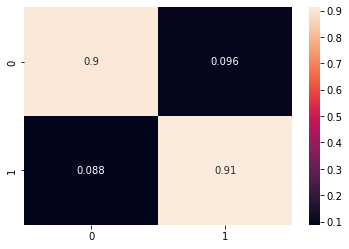

In [191]:
binary_eval(Ytrain, model=tModel_load, predictor=Xtrain_ss)

              precision    recall  f1-score   support

           0       0.97      0.90      0.93      1105
           1       0.73      0.90      0.81       326

    accuracy                           0.90      1431
   macro avg       0.85      0.90      0.87      1431
weighted avg       0.91      0.90      0.90      1431

aucpr :  0.6787
aucroc :  0.9011


(0.6787, 0.9011)

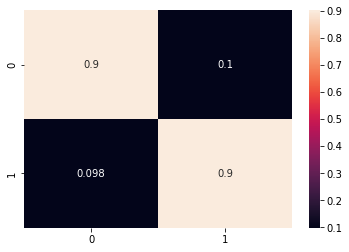

In [192]:
binary_eval(Ytest, model=tModel_load, predictor=Xtest_ss)

## Feature Importance

In [193]:
explainer = shap.TreeExplainer(tModel_load)
# masker = shap.maskers.Independent(data=Xtest_ss)
# explainer = shap.Explainer(
#     tModel_load, masker=masker, feature_names=Xtest_ss.columns, algorithm="linear"
# )
shap_values = explainer.shap_values(Xtrain_ss)

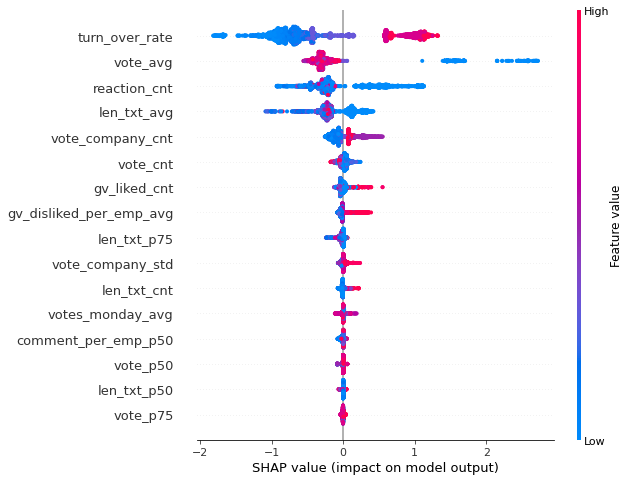

In [194]:
shap.summary_plot(shap_values, features=Xtrain_ss, feature_names=Xtest_ss.columns)

In [195]:
# shap.summary_plot(shap_values, Xtest_ss, plot_type="bar")

In [196]:
# shap.initjs()
# shap.force_plot(explainer.expected_value, shap_values, Xtest_ss)

In [197]:
# shap.dependence_plot('vote_avg', shap_values, Xtest_ss)

In [198]:
vals = np.abs(shap_values).mean(0)
feature_names = Xtest_ss.columns
feature_importance = pd.DataFrame(list(zip(feature_names, vals)),
                                  columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'],
                               ascending=False, inplace=True)

In [199]:
feature_importance.to_csv(PATH_MODEL+'feat_importance_'+VERS+'.csv', index = False)

In [201]:
feature_importance

,col_name,feature_importance_vals
8,turn_over_rate,0.778537
9,vote_avg,0.440313
7,reaction_cnt,0.370421
3,len_txt_avg,0.224743
11,vote_company_cnt,0.135931
10,vote_cnt,0.038475
2,gv_liked_cnt,0.036558
1,gv_disliked_per_emp_avg,0.036444
6,len_txt_p75,0.021872
12,vote_company_std,0.018104
